# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

In [34]:
import warnings
warnings.filterwarnings("ignore")
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from pymorphy2 import MorphAnalyzer
#import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

### Задание № 1 (8 баллов)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF, SVD и LDA. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 12 моделей (три разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF и LDA, иначе точно будет слишком долго)

In [7]:
data = pd.read_csv('data/avito_category_classification.csv')

In [8]:
data

,category_name,description
0,Автомобили,"отличное состояние,обслужиание в салоне"
1,Детская одежда и обувь,В отличном состоянии. Фирма KIKO. Очень теплый...
2,Предложение услуг,"Изготовление ограждений, перил,качелей, турник..."
3,Автомобили,Автомобиль в отличном техническом состоянии. О...
4,Бытовая техника,"Продается газовая плита ""Гефест"" (Белоруссия) ..."
...,...,...
9893,Товары для детей и игрушки,Чтобы посмотреть весь ассортимент нашего магаз...
9894,Детская одежда и обувь,"Весна,осень.74-80.вопросы можно в вайбер,двухс..."
9895,"Одежда, обувь, аксессуары","Кимоно Green Hill. Состояние отличное, рост ..."
9896,Детская одежда и обувь,Б/у кроссовки на девочку. Носили только в спор...


In [9]:
# добавим лемматизацию
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [10]:
data['description_norm'] = data['description'].apply(normalize)

In [11]:
"""pipeline_bow = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])"""

"pipeline_bow = Pipeline([\n    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),\n    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))\n])"

In [12]:
pipeline_svd_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_svd_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_svd_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])
pipeline_svd_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [13]:
pipeline_nmf_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

pipeline_nmf_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_nmf_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_nmf_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [14]:
pipeline_lda_rf = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

pipeline_lda_knn = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

pipeline_lda_sgd = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])

pipeline_lda_etc = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('lda', LatentDirichletAllocation(50)),
    ('clf', ExtraTreesClassifier(n_estimators=100, random_state=0))
])

In [15]:
def eval_table(X, y, pipeline, N=6):
    # зафиксируем порядок классов
    labels = list(set(y))
    
    # метрики отдельных фолдов будет хранить в табличке
    fold_metrics = pd.DataFrame(index=labels)
    # дополнительно также соберем таблицу ошибок
    errors = np.zeros((len(labels), len(labels)))
    
    # создаем стратегию кросс-валидации
    # shuffle=True (перемешивание) - часто критично важно указать
    # т.к. данные могут быть упорядочены и модель на этом обучится
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        # fit-predict как и раньше, но сразу пайплайном
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        # записываем метрику и индекс фолда
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    # таблица для усредненных значений
    # тут мы берем колонки со значениями и усредняем их
    # часто также все метрики сразу суммируют и в конце просто делят на количество фолдов
    # но мы тут помимо среднего также хотим посмотреть на стандартное отклонение
    # чтобы понять как сильно варьируются оценки моделей
    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    # добавим одну колонку со средним по всем классам
    result.loc['mean'] = result.mean().round(2)
    # проценты ошибок просто усредняем
    errors /= N
    
    return result, errors

In [16]:
metrics_svd_rf, errors_svd_rf = eval_table(data['description_norm'], data['category_name'], pipeline_svd_rf)
metrics_svd_knn, errors_svd_knn = eval_table(data['description_norm'], data['category_name'], pipeline_svd_knn)
metrics_svd_sgd, errors_svd_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_sgd)
metrics_svd_etc, errors_svd_etc = eval_table(data['description_norm'], data['category_name'], pipeline_svd_etc)

In [18]:
metrics_lda_rf, errors_lda_rf = eval_table(data['description_norm'], data['category_name'], pipeline_lda_rf)
metrics_lda_knn, errors_lda_knn = eval_table(data['description_norm'], data['category_name'], pipeline_lda_knn)
metrics_lda_sgd, errors_lda_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_lda_sgd)
metrics_lda_etc, errors_lda_etc = eval_table(data['description_norm'], data['category_name'], pipeline_lda_etc)

In [19]:
metrics_nmf_rf, errors_nmf_rf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_rf)
metrics_nmf_knn, errors_nmf_knn = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_knn)
metrics_nmf_sgd, errors_nmf_sgd = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_sgd)
metrics_nmf_etc, errors_nmf_etc = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_etc)

In [26]:
metrics_lda_rf-metrics_nmf_rf

,precision,precision_std,recall,recall_std,f1,f1_std
Товары для детей и игрушки,-0.15,0.01,0.00,0.05,-0.03,0.06
Бытовая техника,-0.67,-0.52,-0.02,-0.02,-0.04,-0.04
Предложение услуг,-0.09,0.04,-0.11,0.01,-0.11,0.01
Телефоны,-0.20,0.04,0.27,0.06,0.17,0.01
Детская одежда и обувь,-0.08,0.13,-0.04,0.07,-0.08,0.04
Мебель и интерьер,-0.28,0.46,-0.14,-0.07,-0.23,-0.09
Ремонт и строительство,-0.16,-0.07,0.01,0.01,0.02,0.03
Автомобили,-0.09,0.02,-0.10,0.07,-0.10,0.06
"Одежда, обувь, аксессуары",0.02,0.06,-0.10,0.11,-0.03,0.01
Квартиры,-0.05,-0.01,-0.05,-0.01,-0.05,-0.01


In [22]:
#metrics_svd_rf - metrics_svd_knn
#metrics_svd_rf - metrics_svd_etc
metrics_svd_rf - metrics_svd_sgd

,precision,precision_std,recall,recall_std,f1,f1_std
Товары для детей и игрушки,0.06,0.02,-0.48,-0.02,-0.41,0.02
Бытовая техника,0.26,0.01,-0.46,-0.03,-0.47,0.00
Предложение услуг,0.02,0.03,-0.30,0.03,-0.19,0.02
Телефоны,0.11,0.01,-0.45,-0.03,-0.30,0.02
Детская одежда и обувь,-0.29,0.00,-0.10,-0.01,-0.22,0.01
Мебель и интерьер,0.08,0.16,-0.60,-0.05,-0.60,-0.02
Ремонт и строительство,0.07,0.14,-0.41,-0.07,-0.40,0.01
Автомобили,-0.01,0.02,-0.32,0.00,-0.20,0.01
"Одежда, обувь, аксессуары",-0.26,-0.03,-0.02,0.01,-0.18,0.00
Квартиры,-0.09,0.01,-0.07,0.00,-0.08,0.01


In [49]:
metrics_lda_rf.loc['mean'].keys()

Index(['precision', 'precision_std', 'recall', 'recall_std', 'f1', 'f1_std'], dtype='object')

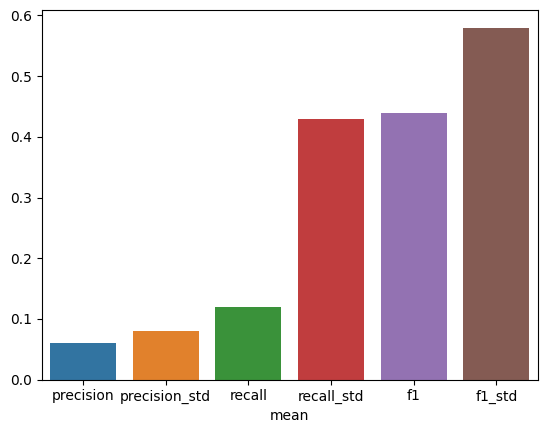

In [54]:
#plt.figure(figsize=(10,8))
g = sns.barplot(x=metrics_lda_rf.loc['mean'].keys(), y=metrics_lda_rf.loc['mean'].values,
            data=metrics_lda_rf.loc['mean'], orient='v')
ax = plt.subplot()
ax = ax.set_xticklabels(metrics_lda_rf.loc['mean'].keys())

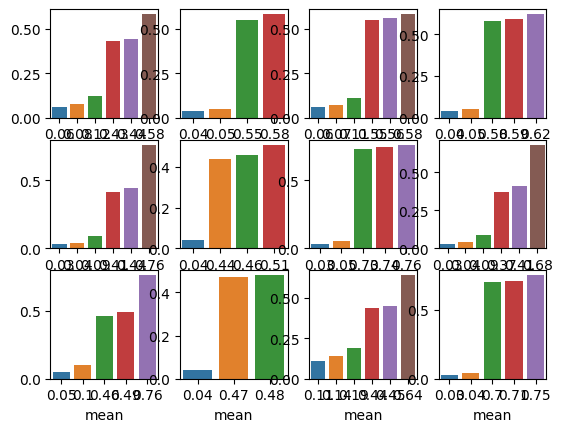

In [63]:
fig, axes = plt.subplots(3, 4)
#axes.set_xticks()
#ax.set_xticklables(['rf','knn', 'sgd', 'etc'])

ax = sns.barplot(x=metrics_lda_rf.loc['mean'].keys(), y=metrics_lda_rf.loc['mean'].values,
            data=metrics_lda_rf.loc['mean'], orient='v', ax=axes[0, 0])
#ax = ax.set_xticklabels(metrics_lda_rf.loc['mean'].keys())

ax = sns.barplot(x=metrics_lda_knn.loc['mean'].keys(), y=metrics_lda_knn.loc['mean'].values,
            data=metrics_lda_knn.loc['mean'], orient='v', ax=axes[0, 1])
#ax = ax.set_xticklabels(metrics_lda_knn.loc['mean'].keys())

ax = sns.barplot(x=metrics_lda_sgd.loc['mean'].keys(), y=metrics_lda_sgd.loc['mean'].values,
            data=metrics_lda_sgd.loc['mean'], orient='v', ax=axes[0, 2])
#ax = ax.set_xticklabels(metrics_lda_sgd.loc['mean'].keys())

ax = sns.barplot(x=metrics_lda_etc.loc['mean'].keys(), y=metrics_lda_etc.loc['mean'].values,
            data=metrics_lda_etc.loc['mean'], orient='v', ax=axes[0, 3])
#ax = ax.set_xticklabels(metrics_lda_etc.loc['mean'].keys())



ax = sns.barplot(x=metrics_svd_rf.loc['mean'].keys(), y=metrics_svd_rf.loc['mean'].values,
            data=metrics_svd_rf.loc['mean'], orient='v', ax=axes[1, 0])
#ax = ax.set_xticklabels(metrics_svd_rf.loc['mean'].keys())

ax = sns.barplot(x=metrics_svd_knn.loc['mean'].keys(), y=metrics_svd_knn.loc['mean'].values,
            data=metrics_svd_knn.loc['mean'], orient='v', ax=axes[1, 1])
#ax = ax.set_xticklabels(metrics_svd_knn.loc['mean'].keys())

ax = sns.barplot(x=metrics_svd_sgd.loc['mean'].keys(), y=metrics_svd_sgd.loc['mean'].values,
            data=metrics_svd_sgd.loc['mean'], orient='v', ax=axes[1, 2])
#ax = ax.set_xticklabels(metrics_svd_sgd.loc['mean'].keys())

ax = sns.barplot(x=metrics_svd_etc.loc['mean'].keys(), y=metrics_svd_etc.loc['mean'].values,
            data=metrics_svd_etc.loc['mean'], orient='v', ax=axes[1, 3])
#ax = ax.set_xticklabels(metrics_svd_etc.loc['mean'].keys())



ax = sns.barplot(x=metrics_nmf_rf.loc['mean'].keys(), y=metrics_nmf_rf.loc['mean'].values,
            data=metrics_nmf_rf.loc['mean'], orient='v', ax=axes[2, 0])
#ax = ax.set_xticklabels(metrics_nmf_rf.loc['mean'].keys())

ax = sns.barplot(x=metrics_nmf_knn.loc['mean'].keys(), y=metrics_nmf_knn.loc['mean'].values,
            data=metrics_nmf_knn.loc['mean'], orient='v', ax=axes[2, 1])
#ax = ax.set_xticklabels(metrics_nmf_knn.loc['mean'].keys())

ax = sns.barplot(x=metrics_nmf_sgd.loc['mean'].keys(), y=metrics_nmf_sgd.loc['mean'].values,
            data=metrics_nmf_sgd.loc['mean'], orient='v', ax=axes[2, 2])
#ax = ax.set_xticklabels(metrics_nmf_sgd.loc['mean'].keys())

ax = sns.barplot(x=metrics_nmf_etc.loc['mean'].keys(), y=metrics_nmf_etc.loc['mean'].values,
            data=metrics_nmf_etc.loc['mean'], orient='v', ax=axes[2, 3])
#ax = ax.set_xticklabels(metrics_nmf_etc.loc['mean'].keys())


### Задание № 2 (2 балла)

С помощью gensim постройте 5 тематических моделей с разными параметрами. Как минимум попробуйте: разное количество тем, alpha и eta параметры (в альфа попробуйте "asymmetric" и "auto" помимо 'symmetric' по дефолту, в eta просто попробуйте разные значения), а также разные параметры фильтрации словаря. 

Оцените каждую из моделей с помощью метрик (перплексии и когерентности), а также визуально, просмотрев получаемые темы. Найдите самую хорошую тему для каждой из моделей.

In [64]:
texts = open('data/wiki_data.txt').read().splitlines()[:5000]
texts = ([normalize(text) for text in texts])

In [65]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=10, max_df=0.4)
X = vectorizer.fit_transform(texts)

In [66]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [67]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [68]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [83]:
lda = gensim.models.LdaModel(corpus, 200, alpha='symmetric', id2word=dictinary, passes=5)

In [84]:
lda.print_topics()

[(171,
  '0.221*"список" + 0.132*"значение" + 0.069*"таблица" + 0.050*"запись" + 0.042*"100" + 0.034*"пример" + 0.028*"севастополь" + 0.025*"условие" + 0.022*"раздел" + 0.022*"колонка"'),
 (93,
  '0.051*"северный" + 0.050*"монголия" + 0.037*"встречаться" + 0.030*"европа" + 0.028*"семейство" + 0.026*"распространить" + 0.022*"личинка" + 0.019*"америка" + 0.019*"яйцо" + 0.018*"растение"'),
 (166,
  '0.106*"полигон" + 0.082*"испытание" + 0.071*"б" + 0.059*"ядерный" + 0.044*"арсенал" + 0.031*"далее" + 0.029*"бомба" + 0.028*"создание" + 0.028*"взрыв" + 0.020*"руководство"'),
 (49,
  '0.181*"убийство" + 0.082*"убитый" + 0.073*"убийца" + 0.072*"торговый" + 0.072*"фамилия" + 0.046*"торговля" + 0.037*"носитель" + 0.028*"статуя" + 0.022*"совершить" + 0.022*"преступный"'),
 (85,
  '0.019*"чтобы" + 0.010*"порода" + 0.009*"остаться" + 0.009*"помощь" + 0.008*"собака" + 0.008*"должный" + 0.007*"вскоре" + 0.007*"друг" + 0.006*"найти" + 0.006*"убить"'),
 (89,
  '0.179*"завод" + 0.064*"производство" + 0.

In [85]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1180.3821646872186

In [86]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [87]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [88]:
coherence_model_lda.get_coherence()

0.49558064814057984

In [77]:
lda = gensim.models.LdaModel(corpus, 200, alpha='asymmetric', id2word=dictinary, passes=5)
lda.print_topics()

[(199,
  '0.054*"воздух" + 0.036*"система" + 0.027*"сигнал" + 0.023*"камера" + 0.020*"сибирский" + 0.020*"антенна" + 0.019*"поток" + 0.018*"патрик" + 0.017*"ветеринарный" + 0.017*"промежуточный"'),
 (197,
  '0.039*"премьер-министр" + 0.038*"магнитный" + 0.031*"переходный" + 0.026*"энергия" + 0.025*"ток" + 0.024*"вероятность" + 0.021*"независимость" + 0.016*"форт" + 0.016*"электрический" + 0.016*"переход"'),
 (198,
  '0.068*"красный" + 0.051*"чёрный" + 0.045*"цвета" + 0.042*"белый" + 0.038*"крыло" + 0.036*"сторона" + 0.035*"цвет" + 0.029*"нижний" + 0.028*"глаз" + 0.027*"пятно"'),
 (192,
  '0.138*"польша" + 0.099*"германия" + 0.085*"польский" + 0.049*"печать" + 0.038*"колония" + 0.030*"коми" + 0.029*"австрия" + 0.026*"франция" + 0.024*"водяной" + 0.024*"немецкий"'),
 (190,
  '0.362*"посёлок" + 0.052*"житель" + 0.046*"поселковый" + 0.038*"километр" + 0.033*"городской" + 0.025*"пгт" + 0.018*"грунтовый" + 0.015*"хозяйство" + 0.015*"статус" + 0.015*"вознесенский"'),
 (195,
  '0.049*"просвеще

In [78]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1185.2655077346408

In [79]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5012267764863864

In [89]:
lda = gensim.models.LdaModel(corpus, 100, alpha='auto', eta='auto', id2word=dictinary, passes=10)
lda.print_topics()

[(82,
  '0.127*"сша" + 0.084*"клетка" + 0.054*"кинг" + 0.041*"американский" + 0.037*"далее" + 0.033*"преступление" + 0.030*"фрэнсис" + 0.026*"белок" + 0.025*"условный" + 0.025*"дэвид"'),
 (47,
  '0.099*"десант" + 0.067*"ferrari" + 0.048*"огонь" + 0.039*"высадка" + 0.038*"артиллерийский" + 0.037*"батарея" + 0.033*"2-й" + 0.029*"1-й" + 0.027*"артиллерия" + 0.021*"жак"'),
 (61,
  '0.047*"белорусский" + 0.044*"степан" + 0.040*"кусок" + 0.036*"сержант" + 0.035*"i" + 0.035*"горьковский" + 0.035*"2-метр" + 0.033*"джек" + 0.029*"белоруссия" + 0.028*"1965"'),
 (25,
  '0.176*"аэропорт" + 0.058*"латвийский" + 0.051*"латвия" + 0.042*"2005" + 0.038*"рига" + 0.032*"региональный" + 0.029*"вс" + 0.028*"регулярный" + 0.023*"обеспечивать" + 0.021*"тип"'),
 (11,
  '0.060*"гонка" + 0.056*"формула" + 0.047*"карта" + 0.030*"команда" + 0.028*"круг" + 0.027*"победа" + 0.023*"гран-при" + 0.019*"подряд" + 0.019*"автомобиль" + 0.019*"пройти"'),
 (54,
  '0.045*"фронт" + 0.038*"войско" + 0.030*"армия" + 0.025*"…" 

In [90]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

605.5023215628206

In [91]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5533050154510811

In [92]:
lda = gensim.models.LdaModel(corpus, 400, alpha='asymmetric', id2word=dictinary, passes=10)
lda.print_topics()

[(395,
  '0.098*"пол" + 0.077*"петров" + 0.066*"двигаться" + 0.055*"арсенал" + 0.054*"быстрый" + 0.052*"защитник" + 0.051*"вилла" + 0.039*"интересный" + 0.037*"депрессия" + 0.033*"горячее"'),
 (398,
  '0.040*"наступление" + 0.038*"овладеть" + 0.033*"наш" + 0.032*"километр" + 0.025*"занять" + 0.020*"река" + 0.019*"направление" + 0.019*"украинский" + 0.017*"бой" + 0.016*"оборона"'),
 (386,
  '0.080*"западный" + 0.056*"бухта" + 0.053*"me" + 0.049*"мыс" + 0.043*"швеция" + 0.041*"1940" + 0.036*"архипелаг" + 0.034*"110" + 0.031*"карта" + 0.030*"41"'),
 (393,
  '0.171*"компания" + 0.024*"частное" + 0.023*"крупный" + 0.022*"сеть" + 0.018*"бизнес" + 0.018*"реализовать" + 0.017*"запустить" + 0.016*"сотрудник" + 0.016*"специализировать" + 0.014*"рынок"'),
 (384,
  '0.352*"1954" + 0.122*"1910" + 0.090*"бакалавр" + 0.068*"иркутский" + 0.040*"никола́" + 0.037*"поступление" + 0.036*"освещать" + 0.033*"иллинойс" + 0.033*"стипендия" + 0.033*"рецензия"'),
 (396,
  '0.217*"смит" + 0.099*"появиться" + 0.0

In [93]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

1028.0496404113687

In [94]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()

0.5071833375538879

In [95]:
lda = gensim.models.LdaModel(corpus, 800, alpha='asymmetric', id2word=dictinary, passes=3)
lda.print_topics()

[(775,
  '0.002*"остров" + 0.002*"залив" + 0.001*"уайт" + 0.001*"шон" + 0.001*"результат" + 0.001*"здесь" + 0.001*"река" + 0.001*"акватория" + 0.001*"пролив" + 0.001*"польский"'),
 (768,
  '0.165*"отдельный" + 0.116*"целое" + 0.112*"сохранение" + 0.105*"поток" + 0.071*"причём" + 0.051*"удержать" + 0.046*"ущерб" + 0.040*"контекст" + 0.029*"видно" + 0.026*"кроме"'),
 (776,
  '0.097*"наука" + 0.061*"профессор" + 0.060*"университет" + 0.049*"институт" + 0.039*"факультет" + 0.038*"научный" + 0.036*"доктор" + 0.031*"кафедра" + 0.022*"диссертация" + 0.022*"окончить"'),
 (762,
  '0.063*"электронный" + 0.055*"николай" + 0.038*"физик" + 0.036*"физический" + 0.035*"разработать" + 0.030*"совместно" + 0.027*"внести" + 0.026*"исследование" + 0.025*"метод" + 0.024*"частица"'),
 (764,
  '0.441*"плечо" + 0.177*"голов" + 0.150*"вперёд" + 0.071*"вверх" + 0.010*"выше" + 0.007*"вертикальный" + 0.002*"подвеска" + 0.001*"сторона" + 0.001*"оркестр" + 0.001*"инструмент"'),
 (785,
  '0.531*"ленин" + 0.217*"ул" 

In [96]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

25938.434324042108

In [ ]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

coherence_model_lda.get_coherence()